# Fit atmosphere parameters Airmass, VAOD, PWV, O3, including clouds OD
# For Pic du Midi Data

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 9th 2020

# imports

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [144]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [145]:
from astropy.table import Table

In [146]:
from scipy import interpolate

In [147]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [148]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [149]:
import libatmscattering as atm

In [150]:
import seaborn as sns

In [151]:
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [152]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [153]:
import scipy.special as sp

In [154]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [155]:
import libLSSTFiltersKG as lsst

In [156]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [157]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [158]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [159]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [160]:
def plot_sed(t,ax):
    """
    
    plot_sed(t, ax) : Plot SED from the astropy table t

    input:
        - t : tables of SED
        - ax : matplotlib axis

    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
        # read the calspec file
        fullfilename=os.path.join(path_sed_calspec,filename)
        print("filename = ",filename,"fullfilename = ", fullfilename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [161]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False,cut=False,file_throuput_effratio="pdm_extracted_throuput_and_o2o1ratio.csv"):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    df_thr=pd.read_csv(file_throuput_effratio,index_col=0)
    
    wl_thr=df_thr["wl"].values
    through=df_thr["throughput"].values
    effratio=df_thr["effratio"].values
    
    # convert wavelength into angstrom
    bp_order1 = S.ArrayBandpass(wl_thr*10, through, name='throughput_o1')
    bp_order2 = S.ArrayBandpass(wl_thr*10, through*effratio, name='throughput_o2')

    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=all_bp_atm[i_atm]* bp_order1
        bp_all_order2=all_bp_atm[i_atm]* bp_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
    
    if cut:
         wlcut_indexes = np.where(wl_atm_ang<7500)[0]
         spectra2[:,wlcut_indexes]=0
        
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [162]:
if 0:
    spectra,spectra2=GetSpectra(sed=s0,wl_atm=wl,atm_transmission=transm[:22,:],order2=True,cut=True,file_throuput_effratio=throuputfile)
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        ax.plot(wl,spectra[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

## Functions for Plotting

In [163]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot estimated parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [164]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [165]:
def plotcorrelation(ax,all_Y):
    """
    """
    
    df=pd.DataFrame(data=all_Y,columns=['VAOD', 'PWV', 'OZONE',"CLD-OD"])
    Var_Corr = df.corr()
    mask_ut=np.triu(np.ones(Var_Corr.shape)).astype(np.bool)
    mask_lt=np.logical_not(np.tril(np.ones(Var_Corr.shape)).astype(np.bool))
    
    sns.heatmap(Var_Corr,mask=mask_lt,vmin=0, vmax=1 ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax,cmap="jet")

In [166]:
#-----------------------------------------------------------------------------------------------------------------------
def plot_ml_result(Yin,Yout,mode,title):
    """
    plot_ml_result(Yin,Yout,mode,title)

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param(0, ax, Yin, Yout, mode)

    ax = fig.add_subplot(222)
    plot_param(1, ax,Yin, Yout, mode)

    ax = fig.add_subplot(223)
    plot_param(2, ax, Yin, Yout, mode)

    ax = fig.add_subplot(224)
    plot_param(3, ax, Yin, Yout, mode)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#--------------------------------------------

In [167]:
def histo_ml_result(Yin, Yout, title):
    """

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param_histo(0, ax, Yin, Yout)

    ax = fig.add_subplot(222)
    plot_param_histo(1, ax, Yin, Yout)

    ax = fig.add_subplot(223)
    plot_param_histo(2, ax, Yin, Yout)

    ax = fig.add_subplot(224)
    plot_param_histo(3, ax, Yin, Yout)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#---------------------------------------------

In [168]:
def plot_regularisation_coeff(alphas,alpha0,allcoefs,title):
    """

    plot_regularisation_coeff(alpha,all_coeff,title) : plot coefficient vrt regularisation parameter

    :param alphas: regularisation parameters
    : param alpha0 : vertical line
    :param allcoefs: coefficient
    :param title: title
    :return:
    """

    N = allcoefs.shape[2] # number of coefficients
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(221)
    for idx in np.arange(allcoefs.shape[2]):
        ax1.plot(alphas, allcoefs[:, 0, idx], color=all_colors[idx])
    ax1.set_xscale('log')
    ax1.axvline(x=alpha0, color='red')
    ax1.set_ylabel('weights - vaod')
    ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
    ax1.grid(True)
    ax1.set_title(title)

    ax2 = fig.add_subplot(222, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax2.plot(alphas, allcoefs[:, 1, idx], color=all_colors[idx])
    ax2.axvline(x=alpha0, color='red')
    ax2.set_xscale('log')
    ax2.set_ylabel('weights - H2O')
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
    ax2.grid(True)

    ax3 = fig.add_subplot(223, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax3.plot(alphas, allcoefs[:, 2, idx], color=all_colors[idx])
    ax3.axvline(x=alpha0, color='red')
    ax3.set_ylabel('weights - O3')
    ax3.set_xscale('log')
    ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
    ax3.grid(True)

    ax4 = fig.add_subplot(224, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax4.plot(alphas, allcoefs[:, 3, idx], color=all_colors[idx])
    ax4.axvline(x=alpha0, color='red')
    ax4.set_ylabel('weights - CLD')
    ax4.set_xscale('log')
    # ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
    ax4.set_xlim(ax4.get_xlim())  # reverse axis
    ax4.grid(True)

    plt.xlabel('alpha')
    plt.axis('tight')

    plt.tight_layout()
    plt.show()



# GetAtmTransparency

In [169]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

# Initialisation

In [170]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 02:40:28
NY time: 05:40:28
London time: 10:40:28
Paris time: 11:40:28


# Configuration

In [171]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [172]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-08 11:40:28,134 MacBook-Pro-de-admin.local __main__[68063] INFO LA time:02:40:28
2020-10-08 11:40:28,135 MacBook-Pro-de-admin.local __main__[68063] INFO NY time:05:40:28
2020-10-08 11:40:28,136 MacBook-Pro-de-admin.local __main__[68063] INFO London time:10:40:28
2020-10-08 11:40:28,137 MacBook-Pro-de-admin.local __main__[68063] INFO Paris time:11:40:28
2020-10-08 11:40:28,138 MacBook-Pro-de-admin.local __main__[68063] INFO ************************ START *********************


In [173]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [174]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-08 11:40:28,151 MacBook-Pro-de-admin.local __main__[68063] INFO Configuration file : config/default.ini


In [175]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-10-08 11:40:28,159 MacBook-Pro-de-admin.local __main__[68063] INFO 1) Configuration


In [176]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [177]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    # filename of throuput and order
    throuputfile  =   config['GENERAL']['throuputfile']

    object        =   config['GENERAL']['object']
    sedfilename   =   config['GENERAL']['sedfilename']
    WLMINSEL      =   float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      =   float(config['GENERAL']['WLMAXSEL'])
    
    
    
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)


if 'MLFIT'in config_section:
    input_file = config['MLFIT']['inputfile']
    input_dir = config['MLFIT']['inputdir']

    packetsize = int(config['MLFIT']['packetsize'])
    maxnbpacket = int(config['MLFIT']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]
else:
    msg="Configuration file : Missing section MLFIT in config file {config_filename} !"
    logger.error(msg)
    

# Atmospheric transparency file and selection

In [178]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [179]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [180]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [181]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [182]:
NFiles=len(selected_files)

# Read simulated atmospheric transparency

In [183]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [184]:
logger.info(header)

2020-10-08 11:40:28,938 MacBook-Pro-de-admin.local __main__[68063] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [185]:
idx_cld

5

In [186]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [187]:
transm=datain[:,idx_res:]

In [188]:
wl.shape

(951,)

In [189]:
transm.shape

(10000, 951)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
2020-10-08 11:40:30,122 MacBook-Pro-de-admin.local matplotlib.legend[68063] WARNING No handles with labels found to put in legend.


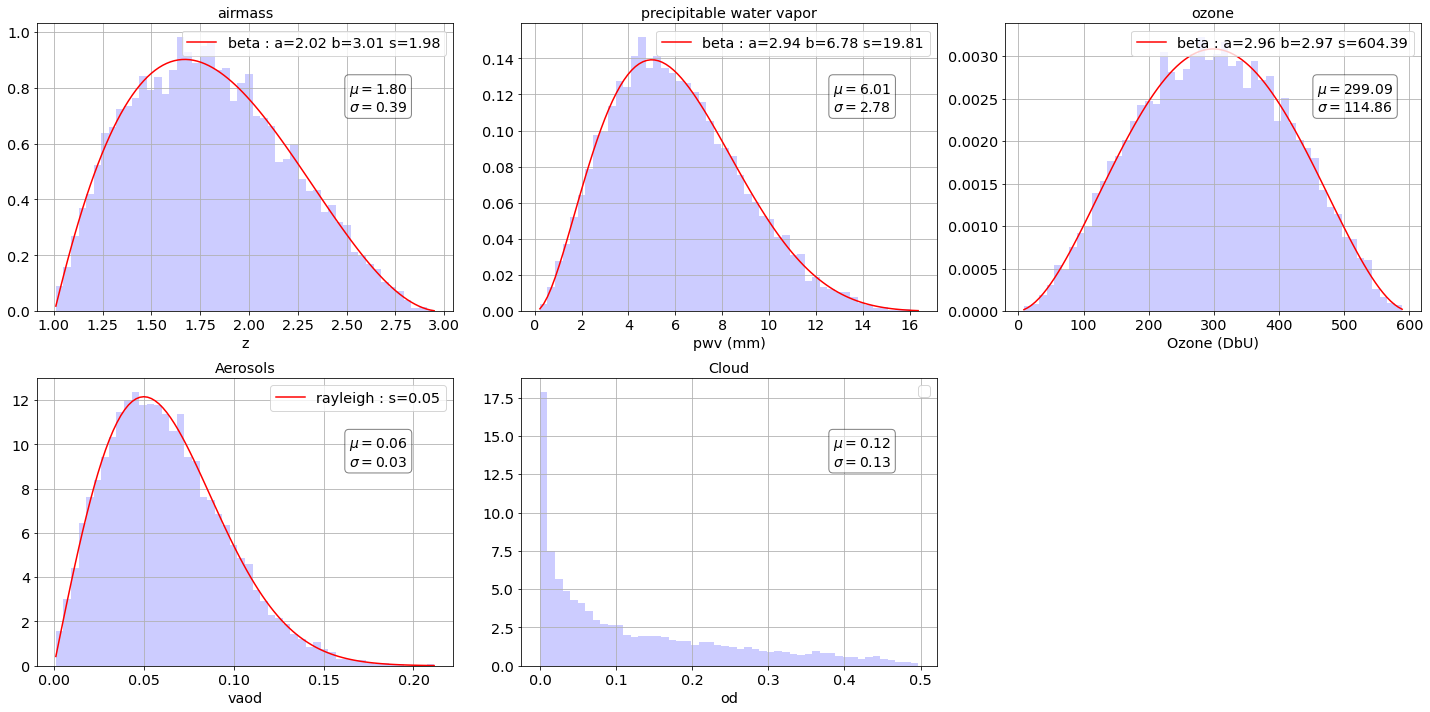

In [190]:
def GetDistribFromName(name):
    """
    
    GetDistribFromName(name): Get distribution from name in config file
    
    input arg:
    
    - name : string name of the distribution
    
    """
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,10))
    ax1=fig.add_subplot(231)
    ax2=fig.add_subplot(232)
    ax3=fig.add_subplot(233)
    ax4=fig.add_subplot(234)
    ax5=fig.add_subplot(235)
    #ax6=fig.add_subplot(326)

    # -----------------  airmass
    mu=np.average(airmass)
    sigma=np.std(airmass)
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))


    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax1.text(0.75, 0.8, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    #----------------pwv--------------------
    
    mu=np.average(pwv)
    sigma=np.std(pwv)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    ax2.text(0.75, 0.8, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    #-------------- Ozone
    
    mu=np.average(ozone)
    sigma=np.std(ozone)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    ax3.text(0.75, 0.8, textstr, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    #-------------------- VAOD
    
    mu=np.average(vaod)
    sigma=np.std(vaod)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    ax4.text(0.75, 0.8, textstr, transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    #-------------- clouds
    
    mu=np.average(cld)
    sigma=np.std(cld)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    ax5.text(0.75, 0.8, textstr, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
        
        
    plt.tight_layout()

### Select wavelength range

Truncate wavelength

In [191]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [192]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [193]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

### Remove rayleigh component

In [194]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [195]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [196]:
transm=transm_tot

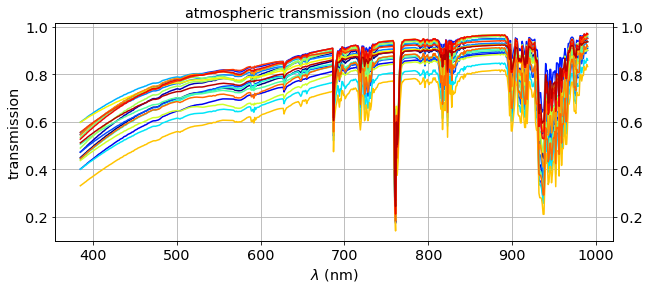

In [197]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("transmission")
    ax.set_title("atmospheric transmission (no clouds ext)")
    ax.grid()
        
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    #ax1.grid()
    

In [198]:
NWL=wl.shape[0]

In [199]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [200]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

## Clouds

## clouds in input data

In [201]:
transm_cloud=np.exp(-cld*airmass)
transm_cloud_arr=np.exp(-cldarr*airmassarr)

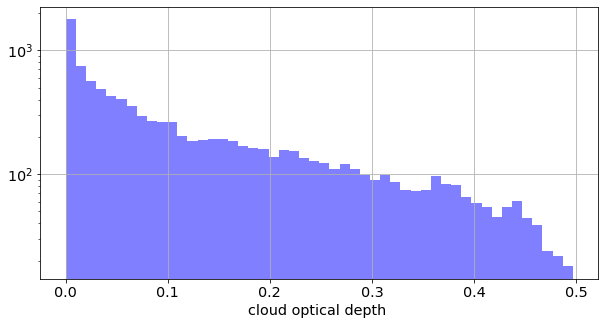

In [202]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))

    ax = fig.add_subplot(111)
    ax.hist(cld,bins=50,facecolor="b",label="in data",alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel("cloud optical depth ")
    ax.grid()


### concatenate VAOD,PWV, Ozone

In [203]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

# Retrieve the SED

In [204]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))
s0.convert('flam')

In [205]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

### Show examples of SED to use

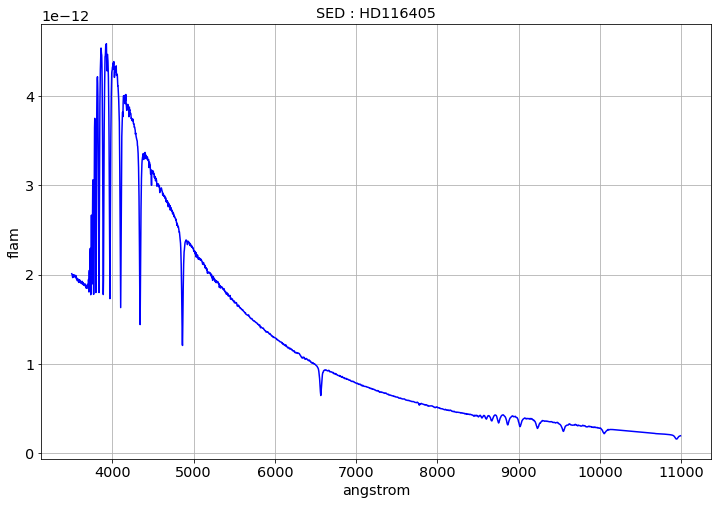

In [206]:
if FLAG_PLOT:   
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(sed_w*10,sed_f/10,"b-")
    ax.set_xlabel(s0.waveunits.name)
    ax.set_ylabel(s0.fluxunits.name)
    title= f"SED : {object}"
    ax.set_title(title)
    ax.grid()

### Get the Spectrum

In [207]:

sed_filename = sedfilename
sed_objname = object
sed_fullfilename = os.path.join(path_sed_calspec, sed_filename)

#################
order2 = True
cut    = True
################

if order2:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"

In [208]:
specarrayfile

'spec_HD116405_ord12.npy'

In [209]:
specarrayfile2

'spec2_HD116405_ord2.npy'

## Get the spectra here

In [ ]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=s0,wl_atm=wl,atm_transmission=transm,order2=order2,cut=cut,file_throuput_effratio=throuputfile)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

((atm0 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm0 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectru

((atm129 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm130 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm130 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm131 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm131 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm132 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm132 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm133 * throughput_o1)) does not have a defined binset in the wavecat table. The wavese

((atm246 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm246 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm247 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm247 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm248 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm248 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm249 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm249 * throughput_o2)) does not have a defined binset in the wavecat table. The wavese

((atm370 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm371 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm371 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm372 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm372 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm373 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm373 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm374 * throughput_o1)) does not have a defined binset in the wavecat table. The wavese

((atm493 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm494 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm494 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm495 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm495 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm496 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm496 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm497 * throughput_o1)) does not have a defined binset in the wavecat table. The wavese

((atm618 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm618 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm619 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm619 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm620 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm620 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm621 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm621 * throughput_o2)) does not have a defined binset in the wavecat table. The wavese

((atm743 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm743 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm744 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm744 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm745 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm745 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm746 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm746 * throughput_o2)) does not have a defined binset in the wavecat table. The wavese

((atm865 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm865 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm866 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm866 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm867 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm867 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm868 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm868 * throughput_o2)) does not have a defined binset in the wavecat table. The wavese

((atm991 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm991 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm992 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm992 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm993 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm993 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm994 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm994 * throughput_o2)) does not have a defined binset in the wavecat table. The wavese

((atm1111 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1112 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1112 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1113 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1113 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1114 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1114 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1115 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm1235 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1236 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1236 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1237 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1237 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1238 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1238 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1239 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm1363 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1363 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1364 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1364 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1365 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1365 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1366 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1366 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm1482 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1483 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1483 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1484 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1484 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1485 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1485 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1486 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm1604 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1604 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1605 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1605 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1606 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1606 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1607 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1607 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm1659 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1659 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1660 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1660 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1661 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1661 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1662 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1662 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm1780 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1780 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1781 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1781 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1782 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1782 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1783 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1783 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm1896 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1896 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1897 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1897 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1898 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1898 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1899 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm1899 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2017 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2017 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2018 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2018 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2019 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2019 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2020 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2020 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2135 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2135 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2136 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2136 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2137 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2137 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2138 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2138 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2248 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2249 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2249 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2250 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2250 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2251 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2251 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2252 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm2365 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2366 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2366 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2367 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2367 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2368 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2368 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2369 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm2488 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2488 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2489 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2489 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2490 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2490 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2491 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2491 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2559 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2559 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2560 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2560 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2561 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2561 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2562 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2562 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2669 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2669 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2670 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2670 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2671 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2671 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2672 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2672 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm2783 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2784 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2784 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2785 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2785 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2786 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2786 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2787 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm2900 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2900 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2901 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2901 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2902 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2902 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2903 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm2903 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3015 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3016 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3016 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3017 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3017 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3018 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3018 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3019 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm3125 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3125 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3126 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3126 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3127 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3127 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3128 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3128 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3234 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3235 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3235 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3236 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3236 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3237 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3237 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3238 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm3345 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3346 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3346 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3347 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3347 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3348 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3348 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3349 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm3455 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3455 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3456 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3456 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3457 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3457 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3458 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3458 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3572 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3572 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3573 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3573 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3574 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3574 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3575 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3575 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3676 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3676 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3677 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3677 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3678 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3678 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3679 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3679 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3782 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3783 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3783 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3784 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3784 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3785 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3785 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3786 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm3895 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3895 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3896 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3896 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3897 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3897 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3898 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3898 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm3980 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3981 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3981 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3982 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3982 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3983 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3983 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm3984 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4092 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4092 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4093 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4093 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4094 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4094 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4095 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4095 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm4175 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4176 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4176 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4177 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4177 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4178 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4178 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4179 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4266 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4266 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4267 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4267 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4268 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4268 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4269 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4269 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm4366 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4367 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4367 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4368 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4368 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4369 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4369 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4370 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4480 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4481 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4481 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4482 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4482 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4483 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4483 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4484 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4590 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4591 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4591 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4592 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4592 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4593 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4593 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4594 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4700 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4701 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4701 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4702 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4702 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4703 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4703 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4704 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4818 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4819 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4819 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4820 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4820 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4821 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4821 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4822 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm4916 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4916 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4917 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4917 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4918 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4918 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4919 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm4919 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5030 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5030 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5031 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5031 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5032 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5032 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5033 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5033 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5143 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5143 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5144 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5144 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5145 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5145 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5146 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5146 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5260 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5261 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5261 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5262 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5262 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5263 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5263 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5264 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm5385 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5386 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5386 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5387 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5387 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5388 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5388 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5389 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm5493 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5493 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5494 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5494 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5495 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5495 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5496 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5496 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5604 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5605 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5605 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5606 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5606 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5607 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5607 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5608 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm5720 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5720 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5721 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5721 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5722 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5722 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5723 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5723 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5835 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5835 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5836 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5836 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5837 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5837 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5838 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5838 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm5950 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5951 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5951 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5952 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5952 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5953 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5953 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm5954 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6062 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6062 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6063 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6063 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6064 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6064 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6065 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6065 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm6169 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6170 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6170 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6171 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6171 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6172 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6172 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6173 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6270 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6271 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6271 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6272 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6272 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6273 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6273 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6274 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6386 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6387 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6387 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6388 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6388 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6389 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6389 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6390 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6498 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6499 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6499 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6500 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6500 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6501 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6501 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6502 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6609 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6610 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6610 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6611 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6611 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6612 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6612 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6613 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6724 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6724 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6725 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6725 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6726 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6726 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6727 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6727 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm6839 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6840 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6840 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6841 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6841 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6842 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6842 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6843 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm6881 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6881 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6882 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6882 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6883 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6883 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6884 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6884 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm6984 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6984 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6985 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6985 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6986 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6986 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6987 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm6987 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm7092 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7093 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7093 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7094 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7094 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7095 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7095 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7096 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm7201 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7202 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7202 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7203 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7203 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7204 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7204 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7205 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm7318 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7318 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7319 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7319 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7320 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7320 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7321 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7321 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm7428 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7428 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7429 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7429 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7430 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7430 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7431 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7431 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm7537 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7537 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7538 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7538 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7539 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7539 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7540 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7540 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm7645 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7645 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7646 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7646 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7647 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7647 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7648 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7648 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm7760 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7761 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7761 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7762 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7762 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7763 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7763 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7764 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm7871 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7872 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7872 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7873 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7873 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7874 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7874 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7875 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm7983 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7984 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7984 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7985 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7985 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7986 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7986 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm7987 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm8098 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8098 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8099 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8099 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8100 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8100 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8101 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8101 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm8216 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8217 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8217 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8218 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8218 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8219 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8219 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8220 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm8324 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8325 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8325 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8326 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8326 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8327 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8327 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8328 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm8437 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8437 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8438 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8438 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8439 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8439 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8440 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8440 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm8547 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8547 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8548 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8548 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8549 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8549 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8550 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8550 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm8662 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8662 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8663 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8663 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8664 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8664 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8665 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8665 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm8770 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8771 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8771 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8772 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8772 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8773 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8773 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8774 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm8863 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8863 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8864 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8864 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8865 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8865 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8866 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8866 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm8950 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8950 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8951 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8951 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8952 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8952 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8953 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm8953 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9046 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9047 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9047 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9048 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9048 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9049 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9049 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9050 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm9147 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9147 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9148 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9148 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9149 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9149 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9150 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9150 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9252 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9252 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9253 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9253 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9254 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9254 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9255 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9255 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9339 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9339 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9340 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9340 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9341 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9341 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9342 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9342 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9444 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9444 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9445 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9445 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9446 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9446 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9447 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9447 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9552 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9553 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9553 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9554 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9554 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9555 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9555 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9556 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm9657 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9657 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9658 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9658 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9659 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9659 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9660 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9660 * throughput_o2)) does not have a defined binset in the wavecat table. Th

((atm9766 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9767 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9767 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9768 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9768 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9769 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9769 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9770 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm9886 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9887 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9887 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9888 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9888 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9889 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9889 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9890 * throughput_o1)) does not have a defined binset in the wavecat table. Th

((atm9995 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9995 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9996 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9996 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9997 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9997 * throughput_o2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9998 * throughput_o1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm9998 * throughput_o2)) does not have a defined binset in the wavecat table. Th

In [ ]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra2[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

In [ ]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(spectra*transm_cloud_arr)/airmassarr
else:
    X=spectra*transm_cloud_arr

In [ ]:
X.shape

### Check transmission or spectrum

In [ ]:
if FLAG_PLOT:
    N=50
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())

# Correlation coefficient X - Y

In [ ]:
if FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy],lw=4)
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("ML : Correlation coefficient Y - X")
    ax.grid()
    ax.set_ylim(0,1)

## Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [ ]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [ ]:
FLAG_SCALING=True

In [ ]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

In [ ]:
scaler_X.mean_.shape

In [ ]:
scaler_X.scale_.shape

In [ ]:
scaler_Y.mean_.shape

In [ ]:
scaler_Y.scale_.shape

In [ ]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

In [ ]:
X_train_scaled.shape

In [ ]:
X_val_scaled.shape 

In [ ]:
X_test_scaled.shape 

In [ ]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
    ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [ ]:
if 'LINEARREGRESSION' in config_section:
    FLAG_LINEARREGRESSION = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION']))
    FLAG_LINEARREGRESSION_RIDGE = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION_RIDGE']))
    FLAG_LINEARREGRESSION_LASSO = bool(int(config['LINEARREGRESSION']['FLAG_LINEARREGRESSION_LASSO']))
else:
    msg = f"Configuration file : Missing section LINEARREGRESSION in config file {config_filename} !"
    logger.error(msg)
    sys.exit()


In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [ ]:
reg = linear_model.LinearRegression()

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


In [ ]:
X_train_scaled.shape

In [ ]:
regr.coef_.shape

In [ ]:
nb_tot_test = len(Y_test)
nb_tot_train = len(Y_train)

nsamples_test = np.arange(10, nb_tot_test, 100)
nsamples_train = np.arange(10, nb_tot_train, 100)

In [ ]:
##################################################
# Linear Regression : Learning curve
##################################################

if FLAG_LINEARREGRESSION:
    logger.info('4) Linear Regression, no regularisation')
    
    all_MSE_train = np.zeros(len(nsamples_train))
    all_MSE_test = np.zeros(len(nsamples_test))
    all_MSE_test_full = np.zeros(len(nsamples_train))

    count = 0
    for n in nsamples_train:

        regr = linear_model.LinearRegression(fit_intercept=True)

        if FLAG_SCALING:
            X_train_cut = np.copy(X_train_scaled[:n, :])
            Y_train_cut = np.copy(Y_train_scaled[:n, :])
            if n in nsamples_test:
                X_test_cut = np.copy(X_test_scaled[:n, :])
                Y_test_cut = np.copy(Y_test_scaled[:n, :])
        else:
            X_train_cut = X_train[:n, :]
            Y_train_cut = Y_train[:n, :]
            if n in nsamples_test:
                X_test_cut = X_test[:n, :]
                Y_test_cut = Y_test[:n, :]

        # does the fit
        regr.fit(X_train_cut, Y_train_cut)

        # calculate metric
        # Make predictions using the testing set
        Y_pred_train = regr.predict(X_train_cut)
        if n in nsamples_test:
            Y_pred_test = regr.predict(X_test_cut)

        if FLAG_SCALING:
            Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
        else:
            Y_pred_test_full = regr.predict(np.copy(X_test))

        MSE_train = mean_squared_error(Y_train_cut, Y_pred_train)

        if n in nsamples_test:
            MSE_test = mean_squared_error(Y_test_cut, Y_pred_test)

        if FLAG_SCALING:
            MSE_test_full = mean_squared_error(Y_test_scaled, Y_pred_test_full)
        else:
            MSE_test_full = mean_squared_error(Y_test, Y_pred_test_full)

        all_MSE_train[count] = MSE_train
        all_MSE_test_full[count] = MSE_test_full

        if n in nsamples_test:
            all_MSE_test[count] = MSE_test

        count += 1
        # end of loop

In [ ]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111)
    ax.plot(nsamples_train, all_MSE_train, 'b-o', label="train")
    # ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
    ax.plot(nsamples_train, all_MSE_test_full, 'r:o', label="test")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("$N$")
    ax.set_ylabel("MSE")
    ax.set_title("Linear Regression - No reg : MSE with test vs N")
    ax.grid()
    # ax.set_ylim(1e-6,1e-2)
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax1.set_yscale("log")
    ax1.grid()
    plt.tight_layout()
    plt.show()


In [ ]:
##############
# Final fit
#############

if FLAG_LINEARREGRESSION:
    
    regr = linear_model.LinearRegression(fit_intercept=True)

    if FLAG_SCALING:
        regr.fit(X_train_scaled, Y_train_scaled)
    else:
        regr.fit(X_train, Y_train)

    # calculate metric
    # Make predictions using the testing set

    if FLAG_SCALING:
        Y_pred_test = regr.predict(X_test_scaled)
        Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
        DY = Y_pred_test - Y_test_scaled
    else:
        Y_pred_test = regr.predict(X_test)
        DY = Y_pred_test - Y_test

    if FLAG_SCALING:
        # The mean squared error
        msg='Mean squared error: %.5f' % mean_squared_error(Y_test_scaled, Y_pred_test)
        logger.info(msg)
        # The coefficient of determination: 1 is perfect prediction
        msg='Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test)
        logger.info(msg)
        # Explained variance : 1 is perfect prediction
        msg='Explained variance: %.5f' % explained_variance_score(Y_test_scaled, Y_pred_test)
        logger.info(msg)

    else:
        # The mean squared error
        msg='Mean squared error: %.5f' % mean_squared_error(Y_test, Y_pred_test)
        logger.info(msg)
        # The coefficient of determination: 1 is perfect prediction
        msg='Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test)
        logger.info(msg)
        # Explained variance : 1 is perfect prediction
        msg='Explained variance: %.5f' % explained_variance_score(Y_test, Y_pred_test)
        logger.info(msg)

In [ ]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    plot_ml_result(Y_test, Y_pred_test_inv, mode=0, title="Linear Regression - No reg (with cloud)")
    plot_ml_result(Y_test, Y_pred_test_inv, mode=1, title="Linear Regression - No reg (with cloud)")
    plot_ml_result(Y_test, Y_pred_test_inv, mode=2, title="Linear Regression - No reg (with cloud)")
    #plot_ml_result(Y_test, Y_pred_test_inv, mode=3, title="Linear Regression - No reg (with cloud)")

    histo_ml_result(Y_test, Y_pred_test_inv, title="Linear Regression - No reg (with cloud)")

In [ ]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    plotcorrelation(ax, Y_test)
    ax.set_title("atmospheric param at input")
    ax = fig.add_subplot(122)
    plotcorrelation(ax, Y_pred_test_inv)
    ax.set_title("atmospheric param at output")
    plt.tight_layout()
    plt.suptitle("Linear Regression - No reg (with cloud)", Y=1.02, fontsize=18)
    plt.show()

In [ ]:
if FLAG_LINEARREGRESSION and FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],label=Ylabel[iy],lw=3)
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("Linear regression : Correlation coefficient Y - X")
    ax.grid()
    ax.set_ylim(0,1)

In [ ]:
R=np.corrcoef(x=X[:,0], y=Y[:,0], rowvar=False)

In [ ]:
R.shape

In [ ]:
R

In [ ]:
Y.shape

In [ ]:
X.shape

In [ ]:
R.shape

# Linear Regression with Ridge

In [ ]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [ ]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

In [ ]:
regr_ridge.coef_.shape

## Tune hyper parameter with Ridge

In [ ]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

In [ ]:
allcoefs.shape

In [ ]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [ ]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [ ]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

In [ ]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
#if FLAG_MAG:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
#else:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

In [ ]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
ax.grid()
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [ ]:
allcoefs.shape

In [ ]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [ ]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.axvline(x=alpha_ridge,color='red')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.axvline(x=alpha_ridge,color='red')
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.axvline(x=alpha_ridge,color='red')
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.axvline(x=alpha_ridge,color='red')
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [ ]:
from sklearn import linear_model

In [ ]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [ ]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

In [ ]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

In [ ]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [ ]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [ ]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

In [ ]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
alpha_lasso

In [ ]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [ ]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x=alpha_lasso,color='red')
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.axvline(x=alpha_lasso,color='red')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.axvline(x=alpha_lasso,color='red')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.axvline(x=alpha_lasso,color='red')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [ ]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [ ]:
nsamples_test=np.arange(10,nb_tot_test,100)
nsamples_train=np.arange(10,nb_tot_train,100)

### Leraning curves for linear regression

In [ ]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [ ]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit    
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
        
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
         MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
            
    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
        
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r:o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [ ]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [ ]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
        
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [ ]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [ ]:
alpha_lasso

In [ ]:
alpha_lasso_min

In [ ]:
alpha_lasso_0=1e-3

In [ ]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [ ]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()


In [ ]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.05,fontsize=22)

## Ridge

In [ ]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
ridge.coef_

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (with cloud)",Y=1.05,fontsize=22)

## Lasso

In [ ]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (with cloud)",Y=1.05,fontsize=22)